# Week of 2025.05.19

## TODO
- [ ] Generate cleaner derivitives of light hill stress tensor. 
- [ ] Get accurate atmospheric wave as a result. 

## 1.0 Review latest atmospheric quail model
- Ran with order 1 for atmospheric model. 

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
from helper_code.slip_imports import *
from helper_code.helper_functions import get_local_solver_from_index_func
from helper_code.animate import animate_conduit_pressure

import helper_code.infrasound as infrasound
from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt 

plt.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'

folder_name = "simple_eruption_model"
file_name = "tungurahua_rad_5_v25_conduit"
iterations = 36

In [15]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import processing.mdtools as mdtools

iterations = 69

# Assume solver2D_from is available as in the original code
solver2D_atm1 = get_local_solver_from_index_func("simple_eruption_model", "test_infrasound_v27_atm1")

# Set up figure
fig = plt.figure(figsize=(8, 6))

# Define pressure range for colormap
clims = (-1e3, 1e3)

# Set up colorbar
sm = plt.cm.ScalarMappable(
    norm=colors.Normalize(vmin=clims[0], vmax=clims[1]),
    cmap=plt.get_cmap()
)
cb = plt.colorbar(sm, ax=plt.gca())
cb.set_label("Pressure (Pa)")
x1, p1_0= mdtools.downsample(solver2D_atm1(0), plot_qty="Pressure")

# Animation update function
def update(frame):
    plt.cla()  # Clear current axis
    # Fetch data for current frame
    x1, p1= mdtools.downsample(solver2D_atm1(frame), plot_qty="Pressure")
    # Update plot
    mdtools.plot_mean(x1, p1 - p1_0, clims)
    plt.title(f"Pressure Field at Sec {round(1/2 * frame)}")
    return plt.gca(),

# Create animation
# Assume 100 frames for simulation; adjust based on solver data
ani = animation.FuncAnimation(
    fig,
    update,
    frames=range(0, iterations, 1),  # Adjust range based on available solver indices
    interval=100,  # Time between frames in milliseconds
    blit=False
)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

## 2.0 Divergence and Double divergence of lighthill stress tensor

In [16]:
import helper_code.lighthill as lighthill
import numpy as np
import matplotlib.tri as tri

def solver_from_2D(dom, i):
    solver_func = get_local_solver_from_index_func("simple_eruption_model", f"test_infrasound_v27_atm{dom}")

    return solver_func(i)

# Prep interpolation grid
solver0 = solver_from_2D(1, 0)
physics = solver0.physics
base_x = np.linspace(0, 500, 200)
base_y = np.linspace(-200, 1000, 200)
mg_x, mg_y = np.meshgrid(base_x, base_y, indexing="xy")

solver0_list = [solver_from_2D(dom_idx, 0) for dom_idx in [1,2,3]]
# Compute workload partition
ind_partition = [np.where(tri.Triangulation(
  solver.mesh.node_coords[...,0],
  solver.mesh.node_coords[...,1], 
  triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(mg_x.ravel(), mg_y.ravel()) != -1)[0]
  for solver in solver0_list]

# List of file indices to read
file_index_list = np.arange(0,iterations,1)

In [17]:
# Allocate union (joining all times) U, in spatially-flattened shape
U_union = np.nan * np.empty((file_index_list.size, *mg_x.ravel().shape, 8+physics.NDIMS))

for time_idx, file_idx in enumerate(file_index_list):

	# Load solvers for given time_idx
	solver_list = [solver_from_2D(dom_idx, file_idx) for dom_idx in [1,2,3]]

	for solver, _index_partition in zip(solver_list, ind_partition):
		# Identify physical position (x, y) of points to interpolate at with shape (npoints, 2)
		_phys_pos = np.stack(
			(mg_x.ravel()[_index_partition],
			mg_y.ravel()[_index_partition]),
			axis=1)
		# Identify element indices for all points to interpolate at
		elt_indices = tri.Triangulation(
			solver.mesh.node_coords[...,0],
			solver.mesh.node_coords[...,1], 
			triangles=solver.mesh.elem_to_node_IDs).get_trifinder()(_phys_pos[:,0], _phys_pos[:,1])

		# Identify element node coordinates
		x_tri = solver.mesh.node_coords[solver.mesh.elem_to_node_IDs]
		# Compute global physical-to-reference coordinate mapping
		ref_mapping = lighthill.compute_ref_mapping(x_tri)

		# Interpolate for each point using the correct element, writing to correct index in global U array
		for (write_idx, x_point, ie) in zip(_index_partition, _phys_pos, elt_indices):
			# For element containing point, compute reference coordinate of sampling point
			ref_coords_loc = np.einsum("ij, j -> i",
																ref_mapping[ie,...],
																x_point - x_tri[ie,0,:])
			# Evaluate basis at reference coordinate
			U_union[time_idx,write_idx,:] = (solver.state_coeffs[ie,0,:] * (1 - ref_coords_loc[0] - ref_coords_loc[1]))

In [18]:
# Evaluate temperature using interpolated state, migrate to meshgrid shape (time_indices, mg_x.shape[0], mg_x.shape[1])
T_interp = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
yM = np.reshape(U_union[...,2:3] / rho, (file_index_list.size, *mg_x.shape))


t_range = np.linspace(0, 13.8, T_interp.shape[0])

In [19]:
rho = U_union[...,0:3].sum(axis=-1, keepdims=True)
u = U_union[:,:,3:4] / rho
v = U_union[:,:,4:5] / rho

# Pull rho, u, v
mg_u = np.reshape(u, (file_index_list.size, *mg_x.shape))
mg_v = np.reshape(v, (file_index_list.size, *mg_x.shape))
mg_T = np.reshape(physics.compute_variable("Temperature", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p = np.reshape(physics.compute_variable("Pressure", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_rho = np.reshape(rho, (file_index_list.size, *mg_x.shape))
mg_c = np.reshape(physics.compute_variable("SoundSpeed", U_union).squeeze(axis=2), (file_index_list.size, *mg_x.shape))
mg_p0 = mg_p[0,...]

/Users/paxton/git/quail_volcano/src/physics/multiphasevpT/multiphasevpT.py:279: RuntimeWarning: invalid value encountered in sqrt
  varq = np.sqrt(get_Gamma()*get_pressure()/(arhoA+arhoWv+arhoM)*get_Psi1())


In [20]:
# Grid dimensions
dx = np.diff(mg_x[0:1,:], axis=1)
dy = np.diff(mg_y[:,0:1], axis=0)
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]

# Grid-center differentiation
u_foldx = (0.5 * (mg_u[:,:,1:] + mg_u[:,:,:-1]))
u_foldy = (0.5 * (mg_u[:,1:,:] + mg_u[:,:-1,:]))
dudy = np.diff(u_foldx, axis=1) / dy
dudx = np.diff(u_foldy, axis=2) / dx

v_foldx = (0.5 * (mg_v[:,:,1:] + mg_v[:,:,:-1]))
v_foldy = (0.5 * (mg_v[:,1:,:] + mg_v[:,:-1,:]))
dvdy = np.diff(v_foldx, axis=1) / dy
dvdx = np.diff(v_foldy, axis=2) / dx

mg_c0 = mg_c[0,...]
# Grid-center coordinates
center_x = 0.5 * (mg_x[:,1:] + mg_x[:,:-1])[:-1,:]
center_y = 0.5 * (mg_y[1:,:] + mg_y[:-1,:])[:,:-1]
# Interior grid-center coordinates
int_x = center_x[1:-1,1:-1]
int_y = center_y[1:-1,1:-1]

### Double divergence nonlinear 

In [21]:
# Evaluate matrix T
T00_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho
T01_nonlinear = np.zeros_like(mg_rho)
T10_nonlinear = np.zeros_like(mg_rho)
T11_nonlinear = mg_p - mg_c0*mg_c0 * mg_rho

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_nonlinear, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_nonlinear[:,1:,:] + T00_nonlinear[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_nonlinear[:,:,1:] + T11_nonlinear[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_nonlinear = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

### Double divergence inertial

In [26]:
# Evaluate matrix T
T00_inertial = mg_rho * mg_u * mg_u
T01_inertial = mg_rho * mg_u * mg_v
T10_inertial = mg_rho * mg_v * mg_u
T11_inertial = mg_rho * mg_v * mg_v

# Mixed derivative (symmetric)
d2T01 = (np.diff(np.diff(T01_inertial, axis=-1), axis=-2) / dx) / dy

# d^2(T00)/dx^2
T00_foldy = 0.5 * (T00_inertial[:,1:,:] + T00_inertial[:,:-1,:])
d2T00 = T00_foldy[:,:,3:] - T00_foldy[:,:,2:-1] - T00_foldy[:,:,1:-2] + T00_foldy[:,:,0:-3]
# d^2(T11)/dy^2
T11_foldx = 0.5 * (T11_inertial[:,:,1:] + T11_inertial[:,:,:-1])
d2T11 = T11_foldx[:,3:,:] - T11_foldx[:,2:-1,:] - T11_foldx[:,1:-2,:] + T11_foldx[:,0:-3,:]

# Evaluate Lighthill analogy source at cell center, for interior cells (discard boundary cells)
dijTij_inertial = d2T00[:,1:-1,:] + 2 * d2T01[:,1:-1,1:-1] + d2T11[:,:,1:-1]

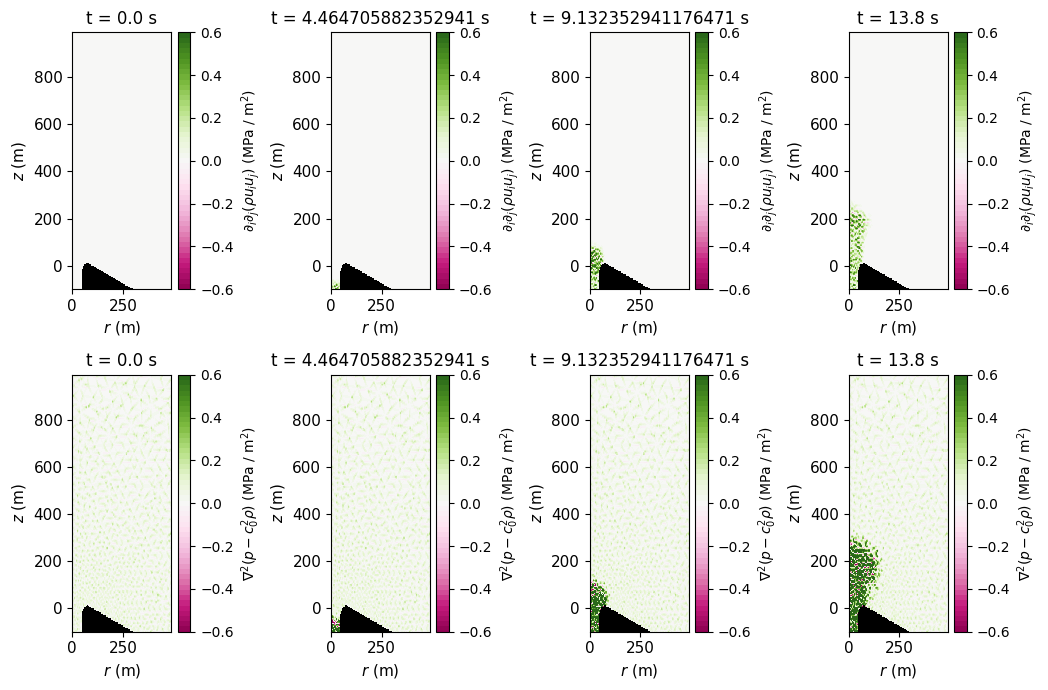

In [ ]:
import matplotlib
fig, ax = plt.subplots(2, 4, figsize=(10.5,7))

levels = np.linspace(-.6e6, .6e6, 50) / 1e6
# t_indices = [3, 9, 36, 72]
t_indices = [0, 22, 45, 68]


for i, t_ind in enumerate(t_indices):
  ax[0,i].set_facecolor("black")
  cf = ax[0,i].contourf(int_x, int_y, np.clip(dijTij_inertial[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\partial_i \partial_j (\rho u_i u_j)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[0,i].set_xlim(0, 490)
  ax[0,i].set_ylim(-100, 990)
  #ax[0,i].set_aspect('equal')
  ax[0,i].set_xlabel("$r$ (m)")
  ax[0,i].set_ylabel("$z$ (m)")
  curr_ax = ax[0,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[0,i].set_title(f"t = {t_range[t_ind]} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

# fig.tight_layout()
  
# fig, ax = plt.subplots(1, 3, figsize=(8.5,3.5))

levels = np.linspace(-0.6e6, 0.6e6, 50) / 1e6
# t_indices = [3, 9, 36, 72]
t_indices = [0, 22, 45, 68]

for i, t_ind in enumerate(t_indices):
  ax[1,i].set_facecolor("black")
  cf = ax[1,i].contourf(int_x, int_y, np.clip(dijTij_nonlinear[t_ind,:,:] / 1e6, levels[0], levels[-1]), levels=levels, cmap=matplotlib.cm.PiYG)
  cb = fig.colorbar(cf, label=r"$\nabla^2 (p - c_0^2 \rho)$ (MPa / m${}^2$)",
                    # format=matplotlib.ticker.FormatStrFormatter('%.3e')
                    )
  ax[1,i].set_xlim(0, 490)
  ax[1,i].set_ylim(-100, 990)
  #ax[1,i].set_aspect('equal')
  ax[1,i].set_xlabel("$r$ (m)")
  ax[1,i].set_ylabel("$z$ (m)")
  curr_ax = ax[1,i]
  for item in ([curr_ax.xaxis.label, curr_ax.yaxis.label] +
                curr_ax.get_xticklabels() + curr_ax.get_yticklabels()):
    item.set_fontsize(11)
  cb.set_ticks(np.linspace(levels[0], levels[-1], 7))
  ax[1,i].set_title(f"t = {t_range[t_ind]} s")
  # cb.ax.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%e'))

fig.tight_layout()
plt.draw()

### Single divergence nonlinear

In [24]:
Nt, Nx, Ny = mg_p.shape

# Central differences using np.diff (second difference)
d_p_dx0 = np.diff(mg_p, n=2, axis=1) / (2 * dx[0, 0])
d_p_dx1 = np.diff(mg_p, n=2, axis=2) / (2 * dy[0, 0])
d_rho_dx0 = np.diff(mg_rho, n=2, axis=1) / (2 * dx[0, 0])
d_rho_dx1 = np.diff(mg_rho, n=2, axis=2) / (2 * dy[0, 0])
    
# Pad arrays to restore original shape (Nx, Ny)
diTij_nonlinear = np.zeros((2, Nt, Nx, Ny))

d_c0_dx0 = np.diff(mg_c0, n=2, axis=0) / (2 * dx[0, 0])
d_c0_dx1 = np.diff(mg_c0, n=2, axis=1) / (2 * dy[0, 0])
diTij_nonlinear[0, :, 1:-1, :] = d_p_dx0 - mg_c0[1:-1, :]**2 * d_rho_dx0 - 2 * mg_c0[1:-1, :] * mg_rho[:, 1:-1, :] * d_c0_dx0
diTij_nonlinear[1, :, :, 1:-1] = d_p_dx1 - mg_c0[:, 1:-1]**2 * d_rho_dx1 - 2 * mg_c0[:, 1:-1] * mg_rho[:, :, 1:-1] * d_c0_dx1

In [25]:
clims = [-5e6, 5e6]

fig, ax = plt.subplots(1, 2)

img = ax[0].imshow(diTij_nonlinear[0,0], aspect='auto', vmin=clims[0], vmax=clims[1], extent=[int_x[0,0], int_x[0,-1], int_y[-1,0], int_y[0, 0]], cmap=matplotlib.cm.PiYG)
img2 = ax[1].imshow(diTij_nonlinear[1,0], aspect='auto', vmin=clims[0], vmax=clims[1], extent=[int_x[0,0], int_x[0,-1], int_y[-1,0], int_y[0, 0]], cmap=matplotlib.cm.PiYG)

plt.colorbar(img)
plt.colorbar(img2)

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.6)
plt.suptitle("Divergence of Lighthill Tensor")

ax[0].set_title('x component')
ax[0].set_ylabel('height (m)')
ax[0].invert_yaxis()

ax[1].set_title('y component')
ax[1].set_xlabel('radius (m)')
ax[1].invert_yaxis()


# Update function for animation
def update(i):
    img.set_array(diTij_nonlinear[0,i])
    img2.set_array(diTij_nonlinear[1,i])
    return [img, img2]

# Create animation
ani = FuncAnimation(fig, update, frames=np.arange(len(t_range)), 
                    interval=50, blit=True)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

## 3.0 Volume integral approach

I am calculating the volume integral over the half-cylindrical region bounded by $r < 400$ and $y > -100$ and $y<500$. 

As we can see in the above graphics, the value of the double divergence of the  lighthill stress tensor falls off outside those bounds. 

The equation we solve below is:

$$
p'(x,t) = \frac{1}{4\pi} \int_v \frac{1}{|x - y|} \frac{\partial^2 T_{ij}}{\partial y_i \partial y_j} (y, t - \frac{|x-y|}{c_0}) dy^3
$$

To solve for pressure as a time series, we can just iterate over the integral for all time steps. We need only calculate the value of $\frac{\partial^2 T_{ij}}{\partial y_i \partial y_j}$ when $t - \frac{|x-y|}{c_0}$ is greater than 0 and less than the end of the simulation. 

- [ ] The $4 \pi$ in the denominator is technically incorrect for our geometry. 
- [ ] Once I feel confident about the soundness of my code, I should decrease the mesh size and time sampling size to get a more precise result. 

In [28]:
import helper_code.lighthill as lighthill

source = dijTij_inertial + dijTij_nonlinear

print(source.shape)

x_obs = (2000, -1000, 0)
c0 = 320 # m/s roughly the speed of sound in air at 5000m in elevation
atmosphere_solid_angle = 4 * np.pi * (2/3)

X = int_x[0]
Y = int_y[:,0]

X = np.linspace(-200, 200, 40)
Y = np.linspace(0, 400, 40)
Z = np.linspace(-200, 200, 40)

points = (t_range, int_y[:,0], int_x[0])

pressure_obs = lighthill.calculate_pressure_as_volume_integral(X, Y, Z, file_index_list, x_obs, points, source, t_range, int_x[0][-1], c0)

(69, 197, 197)
DV size is 1078.9123215158702
Finished time index 0 of 69
Finished time index 10 of 69
Finished time index 20 of 69
Finished time index 30 of 69
Finished time index 40 of 69
Finished time index 50 of 69
Finished time index 60 of 69
Number of contributions: 2067094
r average: 2332.339148403763
Max source value: [1620239.6505334182]


Text(0.5, 1.0, 'Filtered Acoustic Pressure at Observer based on Lighthill analogy')

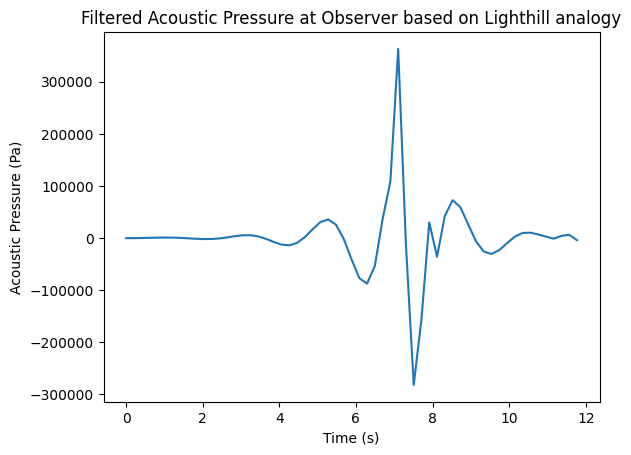

In [30]:
plt.plot(t_range[:-10], lighthill.highpass(pressure_obs[:-10]))
plt.xlabel('Time (s)')
plt.ylabel('Acoustic Pressure (Pa)')
plt.title('Filtered Acoustic Pressure at Observer based on Lighthill analogy')

### 3.1 validate model with known source 

$$
G(\bf{x}, \bf{y}, t) = \frac{\delta(t - \frac{|\bf{x} - \bf{y}|}{c_0})}{4 \pi | \bf{x} - \bf{y}|}
$$
 
So the pressure at any given point can be expressed as 

$$
\begin{align}
p(\bf{x}, t) =& \int \int_V G(\bf{x}, \bf{y}, t - \tau) S(\bf{y}, \tau) d^3y d \tau \\

\end{align}
$$

In this case, because the source term is uniform across the volume $R < 100$ and $Y>0$ and $Y< 100$.

To find the max pressure we would expect, we write the equation:

$$
p_{max} = \frac{1}{4 \pi} \int_V \frac{1}{|x_{obs} - y|} dy 
$$

That can roughly be approximated as

$$
\begin{align}
p_{max} =& \frac{1}{4 \pi} \frac{V}{r_{avg}} \\
p_{max} =& \frac{1}{4 \pi} \frac{\pi * 100^2 * 200}{2300} \\
p_{max} =& 220 [Pa]
\end{align}
$$


In the below example, I show that numerically I arrive at a solution with a max pressure of about 190. 

In [31]:
n = len(t_range)  # Length of the vector
mu = n // 4  # Center of the pulse is 1/4 through the time series
sigma = 5  # Standard deviation (controls pulse width)

nx = len(int_x[0])
ny = len(int_y[:,0])

print(f"nx {nx} and ny {ny}")
# Create index array
x = np.arange(n)

# Compute Gaussian pulse
pulse = np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

source_gaussian = np.zeros(dijTij_inertial.shape)

nan_mask = np.isnan(dijTij_inertial)

for i in range(nx):
    for j in range(ny):
        if int_y[j, 0] > 0 and int_y[j,0] < 200 and int_x[0,i] < 100:
            source_gaussian[:, j, i] = pulse

source_gaussian[nan_mask] = np.nan

clims = [-1, 1]

fig, ax = plt.subplots()

img = ax.imshow(source_gaussian[0], cmap=matplotlib.cm.PiYG, aspect='auto', vmin=clims[0], vmax=clims[1], extent=[int_x[0,0], int_x[0,-1], int_y[-1,0], int_y[0, 0]])
plt.gca().invert_yaxis()
plt.colorbar(img)
ax.set_title('Uniform Gaussian Pulse')
ax.set_xlabel('radius (m)')
ax.set_ylabel('height (m)')


# Update function for animation
def update(i):
    img.set_array(source_gaussian[i])
    return [img]

# Create animation
ani = FuncAnimation(fig, update, frames=np.arange(len(t_range)), 
                    interval=50, blit=True)

display(HTML(ani.to_html5_video()))
plt.close(fig)  # Clean up

nx 197 and ny 197


In [32]:
X = np.linspace(-200, 100, 20)
Y = np.linspace(0, 200, 20)
Z = np.linspace(-100, 100, 20)

points = (t_range, int_y[:,0], int_x[0])

pressure = lighthill.calculate_pressure_as_volume_integral(X, Y, Z, file_index_list, x_obs, points, source_gaussian, t_range, int_x[0][-1], c0)

DV size is 1749.5261699956259
Finished time index 0 of 69
Finished time index 10 of 69
Finished time index 20 of 69
Finished time index 30 of 69
Finished time index 40 of 69
Finished time index 50 of 69
Finished time index 60 of 69
Number of contributions: 253274
r average: 2327.585369386788
Max source value: [0.999994203848918]


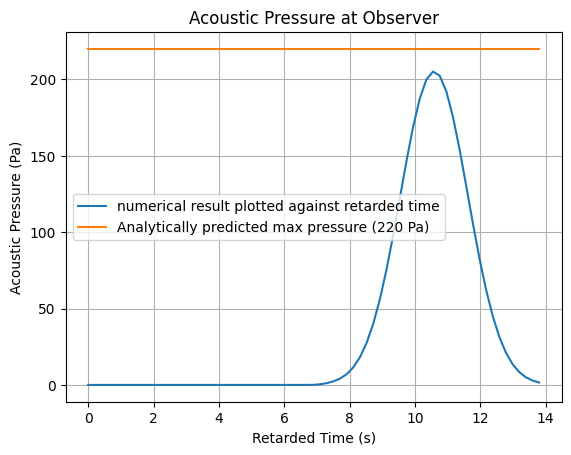

Max pressure 205.15721704510116


In [33]:
r_avg = 2300 #m
retarded_time = t_range - r_avg/c0

# Plot acoustic pressure
plt.plot(t_range, pressure, label="numerical result plotted against retarded time")
plt.plot(t_range, np.ones(t_range.shape)*220, label="Analytically predicted max pressure (220 Pa)")
plt.xlabel('Retarded Time (s)')
plt.ylabel('Acoustic Pressure (Pa)')
plt.title('Acoustic Pressure at Observer')
plt.grid(True)
plt.legend()
plt.show()

print(f"Max pressure {max(pressure)}")

## 4.0 Surface integral flux approach

Eric suggested I solved this problem as a surface integral. Doing so would allow us to remove one spatial dimension at the expense of slightly more complicated math. 

Previously, we had expressed the pressure as the following integral.

$$
\begin{align}
p'(x,t) = \frac{1}{4\pi} \int_v \frac{1}{|x - y|} \frac{\partial}{\partial y_i} \frac{\partial T_{ij}}{\partial y_j} (y, t - \frac{|x-y|}{c_0}) dy^3
\end{align}
$$

Applying the divergence theorm, we are able to rewrite this volume integral as a surface intgral. 


$$
\begin{align}
p'(x,t) = \frac{1}{4\pi} \int_S \frac{1}{|x - y|}  \frac{\partial T_{ij}}{\partial y_j} (y, t - \frac{|x-y|}{c_0}) \cdot \hat{n} dy^2
\end{align}
$$

Let's integrate over the sphere with a radius $a=100m$. Let's review a couple aspects of spherical coordinates. 

$$
\begin{align}
dS =& a^2 \sin \phi d \phi d \theta \\
x =& a \sin \phi \cos \theta \\
y =& a \sin \phi \sin \theta \\
z =& a \cos \phi
\end{align}
$$

So we should be able to rewrite the surface integral as follows: 

$$
p'(x, t) = \frac{1}{4 \pi} \int_0^{\pi/3} \int_0^{2\pi}  \frac{1}{|x - y|} \frac{\partial T_{ij}}{\partial y_j} n_j a^2 \sin \phi d \phi d \theta
$$


In [34]:
points = (range(2), t_range, mg_y[:,0], mg_x[0])

pressure = np.zeros(len(file_index_list))

for i, time_idx in enumerate(file_index_list):
    pressure[i] = lighthill.calculate_surface_integral(diTij_nonlinear, 100, time_idx, t_range, x_obs, c0, points)

    if i % 10 == 0: 
        print(f"Completed step of index {i}")

Completed step of index 0
Completed step of index 10
Completed step of index 20
Completed step of index 30


/var/folders/f7/g7y34v812n5_58yvtkt3mrw40000gn/T/ipykernel_97421/3630953971.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pressure[i] = lighthill.calculate_surface_integral(diTij_nonlinear, 100, time_idx, t_range, x_obs, c0, points)


Completed step of index 40
Completed step of index 50
Completed step of index 60


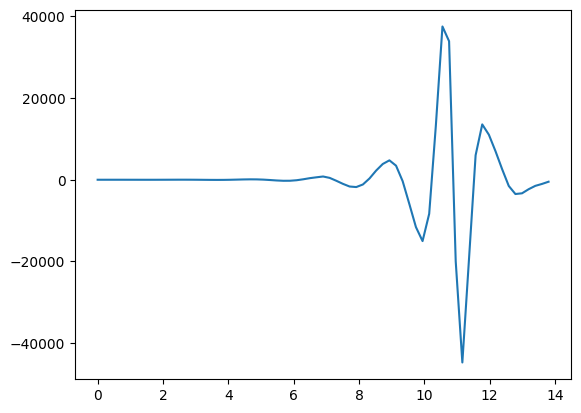

In [35]:
#plt.plot(t_range, pressure)
plt.plot(t_range, lighthill.highpass(pressure))